# Creative extension: Evaluation of the difference in usage across major social platforms

This file contains all the processing we performed to collect the data presented in our datastory, available at: https://yassinekhalfi.github.io/.
Since the milestone P4 of this project also includes the replication of the Figure 2 of the 'Testing Propositions' paper as an individual task, **each team member will process the data for one platform using his own methods to generate the desired figures.** <br><br>
This notebook will be organized as follows: 
- Replication of the figures 1A and 2 using data from Reddit
- Replication of the figures 1A and 2 using data from Stack Overflow
- Replication of the figures 1A and 2 using data from Weibo
- Creation of a side by side comparison of the replicated figures 1A to be used in the datastory
- Creation of a side by side comparison of the replicated figures 2 to be used in the datastory
- Extra stats to be used in the datastory

# Reddit dataset
## 1. Replication of figure 1A: Log-log plot of the complementary cumulative distribution functions of the number of comments per user on Reddit

### 1.1 Data collection
For this step, we will be using data collected using the Reddit PushShift API (https://www.reddit.com/r/pushshift/comments/bcxguf/new_to_pushshift_read_this_faq/), and hosted on Google Cloud. We will use the BigQuery API to collect the data from reddit, focusing on the first years of existence of the platform.<br>
Collecting data from 2005, the year Reddit was created, should allow us to get a representative set of comments for the users. Indeed, we'll have access to the history of their profile from their date of creation.
We'll collect data until for the time period : 2005-2009.

In [1]:
#usual imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#to make calls to the BigQuery API, we'll also need to import the following:
# https://github.com/SohierDane/BigQuery_Helper
from bq_helper import BigQueryHelper
from google.cloud import bigquery
from google.cloud import bigquery_storage
import google.cloud.bigquery_storage_v1.client
import google.auth
from google.oauth2 import service_account
from functools import partialmethod

Let's fetch our data by passing SQL requests to the BigQuery API. For each comment, we are interested in its date of creation, its author and its reference (id)

In [2]:
# Set a two hours timeout for the API calls
google.cloud.bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(google.cloud.bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 

#set up the credentials and the reference to the dataset hosted on Google cloud
credentials = service_account.Credentials.from_service_account_file('My First Project-ff75947ad69d.json')
your_project_id = 'crypto-parser-298009'
bqclient = bigquery.Client(credentials=credentials, project=your_project_id)

#define the SQL request to get the desired information and iterate between datasets to get all comments from 2005 to 2009
#the data is concatenated in the df_reddit dataframe
query_string = """SELECT author, created_utc, id FROM `fh-bigquery.reddit_comments.2005`"""
df_reddit = bqclient.query(query_string).to_dataframe()
for i in range(2006,2009):
    query_string = """SELECT author, created_utc, id FROM `fh-bigquery.reddit_comments."""+str(i)+'`'
    df2_reddit = bqclient.query(query_string).to_dataframe()   
    df_reddit=df_reddit.append(df2_reddit, ignore_index=True)    
df_reddit.head()

,author,created_utc,id
0,[deleted],1135524272,c1996
1,[deleted],1135528315,c1999
2,paulgraham,1135522009,c1992
3,cg84,1135525426,c1997
4,paulgraham,1135521881,c1991


In [3]:
print('number of comments fetched: '+ str(len(df_reddit.id.unique())))
print('number of unique users fetched: '+ str(len(df_reddit.author.unique())))

number of comments fetched: 9388316
number of unique users fetched: 153062


We can see that we fetched more than 9 million comments from more than 150000 users. Many of these profiles seem to have been deleted. Let's remove the comments from deleted users.

In [4]:
#remove comments from deleted users
df_reddit = df_reddit[df_reddit.author != '[deleted]']
print('number of comments fetched from existing users: '+ str(len(df_reddit.id.unique())))

number of comments fetched from existing users: 6351117


Unfortunately, data about the location of Reddit users does not seem to be publically available. This means that if we wanted to reproduce the trends in usage using this dataset, we would only be using the time in the UTC timezone. This would not make much sense, thus we will not use this data to reproduce the figures 2 from the testing propositions paper.<br>

Nevertheless, out of curiosity let's see what those graphs would look like:

### Extra experiment: Circadian rhythms for Reddit using UTC time only.

In [5]:
#we copy our dataframe to an experimental one and run some pre-processing to format it correctly
data=df_reddit.copy()

#convert the creation time to a datetime object and extract the weekday and hour of the day
data['local_datetime'] = pd.to_datetime(data['created_utc'] , unit='s')
data['weekday'] = pd.DatetimeIndex(data['local_datetime']).strftime("%A")
data['time_hour'] = pd.DatetimeIndex(data['local_datetime']).hour

data.head()

,author,created_utc,id,local_datetime,weekday,time_hour
2,paulgraham,1135522009,c1992,2005-12-25 14:46:49,Sunday,14
3,cg84,1135525426,c1997,2005-12-25 15:43:46,Sunday,15
4,paulgraham,1135521881,c1991,2005-12-25 14:44:41,Sunday,14
5,polexa,1135522774,c1994,2005-12-25 14:59:34,Sunday,14
6,alv,1135526478,c1998,2005-12-25 16:01:18,Sunday,16


In [6]:
#group by day and hour of the day
daily_activity_exp = data.groupby(['weekday','time_hour'],as_index=False)

#create a dataframe with the number of posts and unique users at any given hour of any given day
users_stats_reddit_exp=daily_activity_exp.nunique()

users_stats_reddit_exp.head()

,weekday,time_hour,author,created_utc,id,local_datetime
0,Friday,0,11337,38857,41933,38857
1,Friday,1,11023,37603,40485,37603
2,Friday,2,10704,36254,39052,36254
3,Friday,3,10677,36111,38796,36111
4,Friday,4,10202,33666,36070,33666


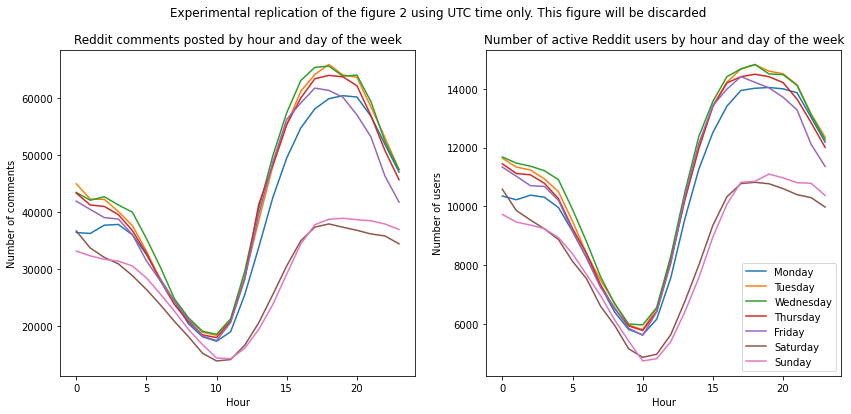

In [7]:
days=['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axs = plt.subplots(1, 2, figsize=(14,6), sharex = True)
fig.suptitle('Experimental replication of the figure 2 using UTC time only. This figure will be discarded')    

for day in days:
    #take data for one day at a time
    daily_reddit_exp=users_stats_reddit_exp[users_stats_reddit_exp.weekday==day]
    #plot number of comments and number of users that commented as a function of the hour
    axs[0].plot(daily_reddit_exp.time_hour,daily_reddit_exp.id,label=day)
    axs[1].plot(daily_reddit_exp.time_hour,daily_reddit_exp.author,label=day)
    

axs[0].set_title('Reddit comments posted by hour and day of the week')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Number of comments')
axs[1].set_title('Number of active Reddit users by hour and day of the week')
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Number of users')
axs[1].legend()

As expected, making sense of these figures is difficult. We could have as an hypothesis that the majority of the reddit userbase is located in the US, especially in the first years of the platform and shift these graphs, but due to the fact that there are several timezones within the US, **will simply disregard these plot for the rest of this project.**  <br> <br>
But let's go back to our focus: creating a similar graph to the figure 1A from our paper.

### 1.2 Pre-processing of the data
In order to reuse the method from the replication task P2, we'll need to obtain a dataframe with a similar formatting to the one we had. Indeed, we'll need to have the number of comments for each user.

In [8]:
#for now our data has the following formatting
df_reddit.head()

,author,created_utc,id
2,paulgraham,1135522009,c1992
3,cg84,1135525426,c1997
4,paulgraham,1135521881,c1991
5,polexa,1135522774,c1994
6,alv,1135526478,c1998


In [9]:
#group our data by author and fetch the number of posts per user
grouped_by_users=df_reddit.groupby(['author'],as_index=False)
users=pd.DataFrame(grouped_by_users.size())

#rename columns for clarity
users=users.rename(columns={'size': 'comments_count'})

users.head()

,author,comments_count
0,-------,1
1,--------------------,7
2,--Aly95--,1
3,--GOD--,25
4,--k,1


Now that the pre-processing is done, we only need to re-use our method to create our figure and observe our CCDF of the number of comments per user on Reddit.
We note that we won't be able to reproduce the N>=0 line since our original dataset is made of comments and thus we don't have any users with 0 comments.
### 1.3 Figure creation

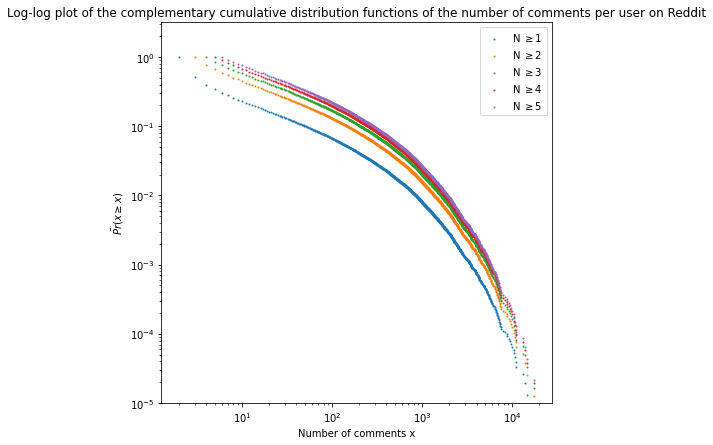

In [10]:
plt.figure(figsize=(7,7))

#We compute the ordonned list of occurences of each number of comments: 
#comments_bincount = [nbr of users with 0 comments, nbr of users with 1 comments, ... , nbr of users with max_number comments]
comments_bincount = np.bincount(users.comments_count)

#Using comments_bincount, we fill comments_sum[i] with the sum of all users having more than i comments:
#comments_sum = [nbr of users with at least 0 comments, nbr of users with at least 1 comments, ... , nbr users with at least max_number comments]
comments_sum=np.ones(len(comments_bincount))*comments_bincount.sum()
comments_sum[1:]-=np.cumsum(comments_bincount)[:-1]
        
#In our case, we won't be able to observe the number of users with 0 comments since our dataset is created from comments    
for i in range(1,6):
    #We isolate the comments_sum values for the sample N>=i and convert to proportions to get the CCDF 
    #(by dividing by the total number of users in the desired sample)
    ccdf=comments_sum[i:]
    ccdf=ccdf/ccdf[0]
    
    #The x vector contains the range of comments for our sample, 
    #we need to adjust its dimensions to avoid having a zero in it (due to the use of the logarithm for our plot) 
    x=list(range(min(users[users.comments_count>=i].comments_count.values.astype(int))+1, \
                 max(users[users.comments_count>=i].comments_count.values.astype(int))+2))
    
    #If the probability does not change between two consecutive x, it means that the element had 0 occurence in comments_bincount
    #In order to eliminate the duplicates in the plot, we fill a dataframe with x and ccdf 
    #and use the df.drop_duplicates function.
    xy=pd.DataFrame(data=None)
    xy['x']=x
    xy['ccdf']=ccdf
    xy=xy.drop_duplicates(subset='ccdf',keep='last')
    plt.scatter(xy.x.values,xy.ccdf.values,s=1,label="N $\geq$"+str(i))
    plt.loglog()

#Plot config
plt.ylim([10**(-5),10**0.5])
plt.xlabel('Number of comments x')
plt.ylabel(r'$\bar{Pr}(x \geq x)$')
plt.title('Log-log plot of the complementary cumulative distribution functions of the number of comments per user on Reddit')
plt.legend()
plt.show()

## 2. Replication of figure 2: Daily and weekly rhythms of Reddit activity

### 2.1 Data collection
This time, we need to be able to determine the user's location to ensure the time of creation of all the comments are comparable. To address this, we will be using only the comments from the "/r/France" subreddit (from the “French Reddit Discussion” on Kaggle https://www.kaggle.com/breandan/french-reddit-discussion), and assuming that those who comment on it in french are located in France.<br>

The dataset is orignally provided as an .xml file, but python scripts are provided to convert it to .csv. It originally contains 556,621 conversations with 1,583,083 comments in total, from several french-speaking reddit communities (subreddits). Since this conversion is extremely time consuming, we will be extracting 100000 conversations from the original set, which contains 272708 comments. We will also need to extract the comments from /r/France to satisfy our hypothesis.

In [11]:
#import the data from our converted dataset
french_discussion = pd.read_csv('data/Reddit_Conv_french.csv')

#rename the columns for clarity
french_discussion=french_discussion.rename(columns={'uid': 'id'})

french_discussion.head()

,Unnamed: 0,link_id,subreddit_id,id,comment_id,score,parent_id,create_utc,text
0,0,8r1kz,2qhjz,1688932,c0a62uj,3,8r1kz,1244576002,Ironie : l'article disant qu'on est plus capab...
1,1,8r1kz,2qhjz,786883,c0a6lmb,1,c0a62uj,1244621120,"Moi-même, j'ai dû me forcer pour arriver jusqu..."
2,2,8sncs,2qhjz,390497,c0aawpk,1,8sncs,1245076061,Service qui sera rendu au contribuable pour la...
3,3,8sncs,2qhjz,32884,c0aaxba,3,c0aawpk,1245077396,Eeeeh oui ! 70 millions pour une loi qui aura ...
4,4,8v13c,2qhjz,796919,c0aj3ov,2,8v13c,1245830384,Est-ce qu'elle a vraiment commis des crimes qu...


In [12]:
print('number of comments: '+ str(len(french_discussion.comment_id.unique())))
print('number of unique users: '+ str(len(french_discussion.id.unique())))

number of comments: 272708
number of unique users: 272708


We can already see a limitation of our dataset: the users are all unique. This limitation will not allow us to create a significative comparison between the comments posted and the active users by hour and day of the week. **We will then focus on the first distribution: the number of comments posted on the platform.**
### 2.2 Pre-processing of the data

In [13]:
#only keep comments from the /r/france subreddit. we can make the assumption that the users that comment in this subreddit are french and thus located in France.
#https://www.reddit.com/r/france/about.json gives us the subreddit id that we need to keep: 2qhjz
france_posts = french_discussion[french_discussion.subreddit_id == '2qhjz']
france_posts.head()

,Unnamed: 0,link_id,subreddit_id,id,comment_id,score,parent_id,create_utc,text
0,0,8r1kz,2qhjz,1688932,c0a62uj,3,8r1kz,1244576002,Ironie : l'article disant qu'on est plus capab...
1,1,8r1kz,2qhjz,786883,c0a6lmb,1,c0a62uj,1244621120,"Moi-même, j'ai dû me forcer pour arriver jusqu..."
2,2,8sncs,2qhjz,390497,c0aawpk,1,8sncs,1245076061,Service qui sera rendu au contribuable pour la...
3,3,8sncs,2qhjz,32884,c0aaxba,3,c0aawpk,1245077396,Eeeeh oui ! 70 millions pour une loi qui aura ...
4,4,8v13c,2qhjz,796919,c0aj3ov,2,8v13c,1245830384,Est-ce qu'elle a vraiment commis des crimes qu...


In [14]:
print('number of comments from /r/France: '+ str(len(france_posts.comment_id.unique())))

number of comments from /r/France: 267840


We can see that we kept the bulk of the data, which is preferable.

In [15]:
#keep only the necessary columns from the dataset
france_posts=france_posts[['id', 'create_utc', 'comment_id']].copy()

#convert the creation time to a datetime object and extract the weekday and hour of the day
#we also add an offset of 1h to go from the utc timezone to the french timezone (utc+1)
france_posts['local_datetime'] = pd.to_datetime(france_posts['create_utc'] , unit='s') + pd.Timedelta(pd.offsets.Hour(1))
france_posts['weekday'] = pd.DatetimeIndex(france_posts['local_datetime']).strftime("%A")
france_posts['time_hour'] = pd.DatetimeIndex(france_posts['local_datetime']).hour
france_posts.head()

,id,create_utc,comment_id,local_datetime,weekday,time_hour
0,1688932,1244576002,c0a62uj,2009-06-09 20:33:22,Tuesday,20
1,786883,1244621120,c0a6lmb,2009-06-10 09:05:20,Wednesday,9
2,390497,1245076061,c0aawpk,2009-06-15 15:27:41,Monday,15
3,32884,1245077396,c0aaxba,2009-06-15 15:49:56,Monday,15
4,796919,1245830384,c0aj3ov,2009-06-24 08:59:44,Wednesday,8


In [16]:
#group by day and hour of the day
daily_activity_reddit = france_posts.groupby(['weekday','time_hour'],as_index=False)

#create a dataframe with the number of posts and unique users at any given hour of any given day
users_stats_reddit=daily_activity_reddit.nunique()
users_stats_reddit.head()

,weekday,time_hour,id,create_utc,comment_id,local_datetime
0,Friday,0,892,891,892,891
1,Friday,1,577,577,577,577
2,Friday,2,318,318,318,318
3,Friday,3,216,216,216,216
4,Friday,4,197,197,197,197


### 2.3 Figure creation

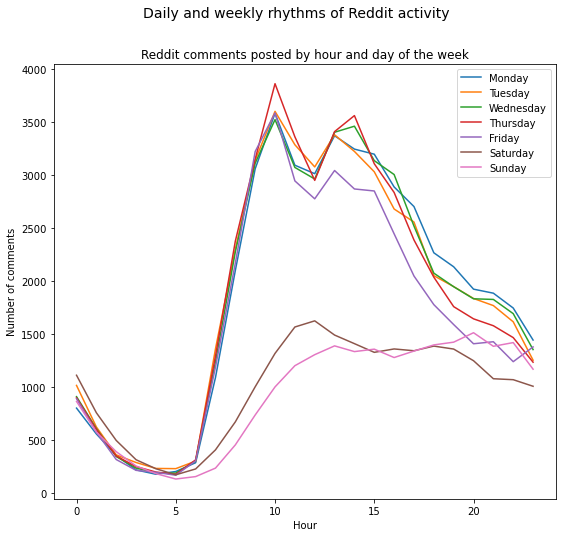

In [18]:
days=['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(9,8))

for day in days:
    #take data for one day at a time
    daily_reddit=users_stats_reddit[users_stats_reddit.weekday==day]
    #plot number of comments as a function of the hour
    plt.plot(daily_reddit.time_hour,daily_reddit.comment_id,label=day)
   
    
plt.title('Reddit comments posted by hour and day of the week')
plt.xlabel('Hour')
plt.ylabel('Number of comments')
plt.suptitle('Daily and weekly rhythms of Reddit activity',fontsize=14)
plt.legend()

# Stack Overflow
## 1. Replication of Figure 1A with Stack Overflow

## Libraries
- bq_helper : Api to simplify use of BigQuery Api, used to do queries and store result in a dataframe
- pandas : to perform operations on dataframes
- matplotlib : for plotting our values
- numpy : for list operations
- os : to set environmental variables

In [1]:
import bq_helper
from bq_helper import BigQueryHelper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# Key to access to bigquery API, to change with own key if need to run in local
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="My Project 17425-755a3d361b77.json"

## Step 1 : Loading the data

The dataset we were using is a public dataset on the BigQuery application administered by Google. To access the dataset we use the Bq Helper API. As input we can give our SQL query to the database, and we have as output a dataframe containing the requested information.

In [2]:
# Initialization of the object allowing us to make queries to the BibQuery api
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")

In [3]:
# SQL query to retrieve users
query_users = """SELECT
  id
FROM
  `bigquery-public-data.stackoverflow.users`
        """
# Call to load the result of the query in a dataframe.
df_users_1a = bq_assistant.query_to_pandas(query_users)

In [4]:
# SQL query to retrieve comments
query_comments = """SELECT
  id, user_id
FROM
  `bigquery-public-data.stackoverflow.comments`
        """
# Call to load the result of the query in a dataframe.
df_comments_1a = bq_assistant.query_to_pandas(query_comments)

In [5]:
df_users_1a.head()

,id
0,11381718
1,11396101
2,11426934
3,11456168
4,11468500
...,...
13566770,13072928
13566771,13073595
13566772,13078389
13566773,13087547


In [6]:
df_comments_1a.head()

,id,user_id
0,92898421,7190570.0
1,92898463,3124256.0
2,92898483,1958500.0
3,92898499,6451573.0
4,92898507,10520116.0
...,...,...
78005038,19796200,1137199.0
78005039,19796255,44729.0
78005040,19796276,1156650.0
78005041,19796287,62255.0


## Step 2 : Filtering the data

We would like to create a plot showing the distribution of the number of comments according to users. To do this, each comment must be associated with a user, which is not the case in our dataframe containing the comments. We will therefore discard the comments associated with no user.


In [7]:
print('Number of comments before deleting those linked to no user : ',len(df_comments_1a))
df_comments_1a.dropna(inplace=True)
print('Number of comments after deleting those linked to no user : ',len(df_comments_1a))

Number of comments before deleting those linked to no user :  78005043
Number of comments after deleting those linked to no user :  76895273


## Step 3 : Processing and Plotting

Now that we have our data, we can process it to make our plot showind distribution of number of comments accross users. In the figure, the Complementary Cumulative Distributive Function (CCDF) of the number of comments per user is represented. 

Here are the different steps for the creation of our plot :

- Group by comments by user and count them
- Create a dataframe with all the users without any comments
- Add users of the platform who have not posted any comments to the dataframe with the count of comments per user
- Compute a list with as value the sum of accounts with a number of comments equal or superior to the position of the entry. eg - at position 2 have the number of users with at least 2 comments 
- Compute a list with the probability pr(X>=x) for each x, for the different minimum values of N. N is the minimum number of tweets for the users. We study the values of N ranging from 0 to 5 (included).
- Plot a scatterplot with the number of comments on the abscissa and the probability (CCDF) on the ordinate.

In [8]:
# Group by user and count, reset index is used to simplify operations on the dataframe
comments_count = df_comments_1a.groupby(by='user_id')['id'].count().reset_index()

In [9]:
# list of users id with 0 comments, constructed with the difference between the set of all users and the set with only the users with at leat one comment
users_0_comments_id = list(set(df_users_1a.id.values) - (set(comments_count.user_id.values)))

# Building the dataset with only users with 0 comments
df_users_0_comments = pd.DataFrame(list(zip(users_0_comments_id,[0]*len(users_0_comments_id))),columns=['user_id','id'])

# We add to the dataframe with the count of comments for users with at leat 1 comment all the users with 0 comments
df_allusers = comments_count.append(df_users_0_comments)

In [ ]:
# The list with the number of occurrences is calculated using bincount function which counts the number of occurrences of each value in array of non-negative ints
occurences = np.bincount(df_allusers.id)

# Cumsum will contais the sum of accounts with a minimum number of tweets for different values.
cumsum = []

for i in range(0,len(occurences)):
    if (occurences[i]==0):
        cumsum.append(np.nan)
    else:
    # Cumsum takes the value of the sum of the elements between an index i and the end of the list occurrences if the number of occurrences of the value i is non-zero.    
        cumsum.append(occurences[i:].sum())

In [ ]:

plt.figure(figsize=(10,10))

# We iterate over the different minimum values 
for n in range(0,6):
    
    # We retrieve the count of values greater than or equal to our minimum value - n -
    y = cumsum[n:]
    
    #To transform our values into probabilities, we divide our values by the sum of all occurrences
    y = y / y[0]
    

    statuses_values = df_allusers[df_allusers.id>=n].id.values.astype(int)
    
    # x is the list containing the possible values for the number of tweets. 
    # We add 1 to the min and max value, to have no 0, our scales are logarithmic, log(0) is undefined and therefore cannot be represented.
    x = range(min(statuses_values)+1, max(statuses_values)+2)
    
    # Size is set to .3 for clarity, and we choose 'o' as marker as in the figure we are trying to replicate
    plt.scatter(x,y,s=.3,label="N >="+str(n),marker='o')


# We give as parameters to our graph the same parameters as the figure for scale, titles and labels.
plt.legend()
plt.loglog()
plt.xlabel('Number of comments')
plt.ylabel(r'$\bar{Pr}(x \geq x)$')
plt.title('Log-log plot of the complementary cumulative distribution functions of the number of comments per user')

plt.show()

## 2. Replication of Figure 2 with Stack Overflow
## Libraries
- bq_helper : Api to simplify use of BigQuery Api, used to do queries and store result in a dataframe
- pandas : to perform operations on dataframes
- matplotlib : for plotting our values
- numpy : for list operations
- os : to set environmental variables
- geopy : to geoencode adresses of users in coordinates
- timezonefinder : to transforme coordinates in timezones
- datetime : to transform fields in datetime
- pytz : to transform coordinates in utc offsets
- random : to make a random selection in the dataset
- mpld3 : transform a pyplot graph into a html file

In [1]:
import bq_helper
from bq_helper import BigQueryHelper
import geopy
from geopy.geocoders import *
from geopy.extra.rate_limiter import RateLimiter
import pandas as pd
from timezonefinder import TimezoneFinder
import datetime, pytz
import numpy as np
import matplotlib.pyplot as plt
import random
import mpld3
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="My Project 17425-755a3d361b77.json"

## Step 1 : Loading the data

The dataset we were using is a public dataset on the BigQuery application administered by Google. To access the dataset we use the Bq Helper API. As input we can give our SQL query to the database, and we have as output a dataframe containing the requested information. To create our graphs we will load user data as well as data of all comments

In [2]:
# Initialization of the object allowing us to make queries to the BibQuery api
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")

In [40]:
# SQL query to retrieve users ids and their location
query_users = """SELECT
  id, location
FROM
  `bigquery-public-data.stackoverflow.users`
        """
## Call to load the result of the query in a dataframe.
df_users = bq_assistant.query_to_pandas(query_users)

In [41]:
# SQL query to retrieve comments ids, user id associated, and creation date of the comments
query_comments = """SELECT
  id, user_id, creation_date
FROM
  `bigquery-public-data.stackoverflow.comments`
        """
## Call to load the result of the query in a dataframe.
df_comments = bq_assistant.query_to_pandas(query_comments)

In [42]:
df_users.head()

,id,location
0,11821986,Bangladesh
1,11254763,Croatia
2,12269505,France
3,13876367,Global
4,2030188,"Palo Alto, CA"
...,...,...
13566770,1625555,India
13566771,8730223,India
13566772,7647683,India
13566773,11280659,India


In [43]:
df_comments.head()

,id,user_id,creation_date
0,115121359,14559682.0,2020-12-02 22:04:20.613000+00:00
1,115121369,14751160.0,2020-12-02 22:04:44.813000+00:00
2,115121375,2704089.0,2020-12-02 22:05:06.053000+00:00
3,115121379,14531220.0,2020-12-02 22:05:13.413000+00:00
4,115121399,9297580.0,2020-12-02 22:06:08.407000+00:00
...,...,...,...
78005038,8853971,655187.0,2011-09-07 21:31:16.353000+00:00
78005039,8854028,319878.0,2011-09-07 21:34:17.253000+00:00
78005040,8854033,933627.0,2011-09-07 21:34:34.103000+00:00
78005041,8854035,237838.0,2011-09-07 21:34:36.523000+00:00


## Step 2 : Filtering the data

We will produce graphs showing user activity by day and hour. In order to be able to transform the creation dates of the comments into local time, we need to keep only the comments associated with a user with a defined location. To do so, firstly we will only keep users with a defined location, afterward we will only keep comments associated with one of those users


In [44]:
# In order to keep only the users with a defined location, we will drop the rows with na
df_users.dropna(inplace=True)

# In order to keep only comments from users with defined location
df_comments = df_comments[df_comments.user_id.isin(df_users.id.values)]

## Step 3 : Processing

Now that we have our raw data, we can process our data for the plots. The data processing is done in several steps, our final goal is to have a data frame with each line corresponding to a tweet with the associated information, including the time of publication in local time and not in UTC. We are going to sample the list of users and only be interested in the activity of this sample of users. The processing being expensive, we can't do it on all users. We are going to take the equivalent of 2% of the users, which still represents more than 20,000 users, i.e. much more than in our initial paper.

The different stages of processing are as follows:

- Randomly sample the list of users id.
- Take in the dataframes of the users and comments only the data relating to the id users present in our sampled list.
- Transform users' addresses into GPS coordinates, and discard users whose coordinates cannot be found.
- Transform the GPS coordinates into a timezone.
- Transforming timezones into utc offset.
- Merges the dataset containing the users' utc offset and the one containing the comments, so that we can have the offset of each comment.
- Transformation of the different date fields into datetime.
- Adding the offset to the date to get the date of the comment in local time.
- Addition of two columns, one containing the day of publication of the comment and the other containing the hour of publication of the tweet.
- We group according to day and hour for graph 2a and we group according to the same criteria for graph 2b, taking care to keep only one entry per user for each day and hour.


In [45]:
# Create list of users with at least one comment by creating a list based on the set if user ids in comment dataframe
users_with_comments = list(set(df_comments.user_id.values))
len(users_with_comments)*0.02

22535.2

In [49]:
# Random sampling of users
sampled_list = random.sample(users_with_comments, 22535)

In [50]:
# Take in our dataframes only the data related to users prensent in our sampled list
comments = df_comments[df_comments.user_id.isin(sampled_list)].copy()
users = df_users[df_users.id.isin(sampled_list)].copy()

In [51]:
# Creation of locator with geopy library, change the subscription key when run on local, timeout at 10 to avoid http exception
locator = AzureMaps(user_agent="myGeocoder",subscription_key='yzufoIvgzkQbe9YP-v3UdJnrySJPG_qgTxNe04KZTKg',timeout=10)

# RateLimiter on our locator, with minimal delay to speed up results
geocode = RateLimiter(locator.geocode, min_delay_seconds=0.1)

# Add in users whole address of the user and its coordinates
users['address'] = users['location'].apply(geocode)

# Drop rows where geocoding failed and we don't have an address
users.dropna(inplace=True)

# Extract coordinates from adress
users['point'] = users['address'].apply(lambda loc: tuple(loc.point) if loc else None)

In [53]:
users.head()

,id,location,address,point
126,9466396,"Bokaro Steel City, Jharkhand, India","(Jamshedpur Tata Steel City, Jharkhand, (22.77...","(22.77901, 86.20391, 0.0)"
151,10661123,"230 Felton Avenue, Collingdale, PA, USA","(230 Felton Avenue, Collingdale, PA 19023, (39...","(39.91388, -75.27566, 0.0)"
189,561385,"Seville, Spain","(Seville, (37.38264, -5.9963))","(37.38264, -5.9963, 0.0)"
214,5629554,shillong,"(Shillong, Meghalaya, (25.57623, 91.88286))","(25.57623, 91.88286, 0.0)"
319,8564714,Estonia,"(Estonia, (59.44269, 24.7532))","(59.44269, 24.7532, 0.0)"
...,...,...,...,...
13565541,2049626,India,"(India, (28.63243, 77.21879))","(28.63243, 77.21879, 0.0)"
13565684,138562,India,"(India, (28.63243, 77.21879))","(28.63243, 77.21879, 0.0)"
13565784,5575246,India,"(India, (28.63243, 77.21879))","(28.63243, 77.21879, 0.0)"
13565785,12017671,India,"(India, (28.63243, 77.21879))","(28.63243, 77.21879, 0.0)"


In [54]:
# Tranform point in discrete coordinates, we add columns to users dataframe
users[['latitude','longitude', 'altitude']] = pd.DataFrame(users['point'].tolist(),index=users.index)

# Create timezoneFinder object
tf = TimezoneFinder()

# First get timezone of the user by applying timezonefinder on coordinates and afterward get the corresponding utc_offset of the timezone
users['timezone'] = users.apply(lambda row: tf.timezone_at(lng=row.longitude, lat=row.latitude), axis=1)
users['utc_offset'] = users.timezone.apply(lambda x : datetime.datetime.now(pytz.timezone(x)).strftime('%z'))

In [55]:
# Rename columns for clarity and merge on same column name 
users_utc_offset = users[['id','utc_offset']].rename(columns={"id":"user_id"})

In [56]:
# Merge comments and users dataframe to get utc offset of each comment
df_timeline = pd.merge(left=comments,right=users_utc_offset,on='user_id')

In [57]:
# We convert our fields containing dates in string format to datetime format using pd.to_datetime
df_timeline.creation_date = pd.to_datetime(df_timeline.creation_date,infer_datetime_format=True)
df_timeline.utc_offset = pd.to_datetime(df_timeline.utc_offset,format="%z").apply(lambda x : x.utcoffset())

# We add the offset to the datetime of creation of our tweet, we use add operation of dates
df_timeline.creation_date = df_timeline.creation_date + df_timeline.utc_offset

In [58]:
# We add the day name and the hour thanks to the built in methods of datetime objects
df_timeline['dayOfWeek'] = df_timeline['creation_date'].dt.day_name()
df_timeline['hour'] = df_timeline['creation_date'].dt.hour

In [59]:
# For 2a we want tweets per hour according to the day, so we group according to dayOfWeek and hour and we count, reset_index is used to simplify slicing afterwards
df_2a = df_timeline.groupby(by=['dayOfWeek','hour'])['id'].count().reset_index()

# For 2b we want active users per hour according to the day, we drop duplicates on the various columns to have only one entry per user for a given day and hour 
# and then we group according to dayOfWeek and hour and we count, reset_index is used to simplify slicing afterwards
df_2b = df_timeline.drop_duplicates(subset=['user_id','dayOfWeek','hour']).groupby(by=['dayOfWeek','hour'])['id'].count().reset_index()

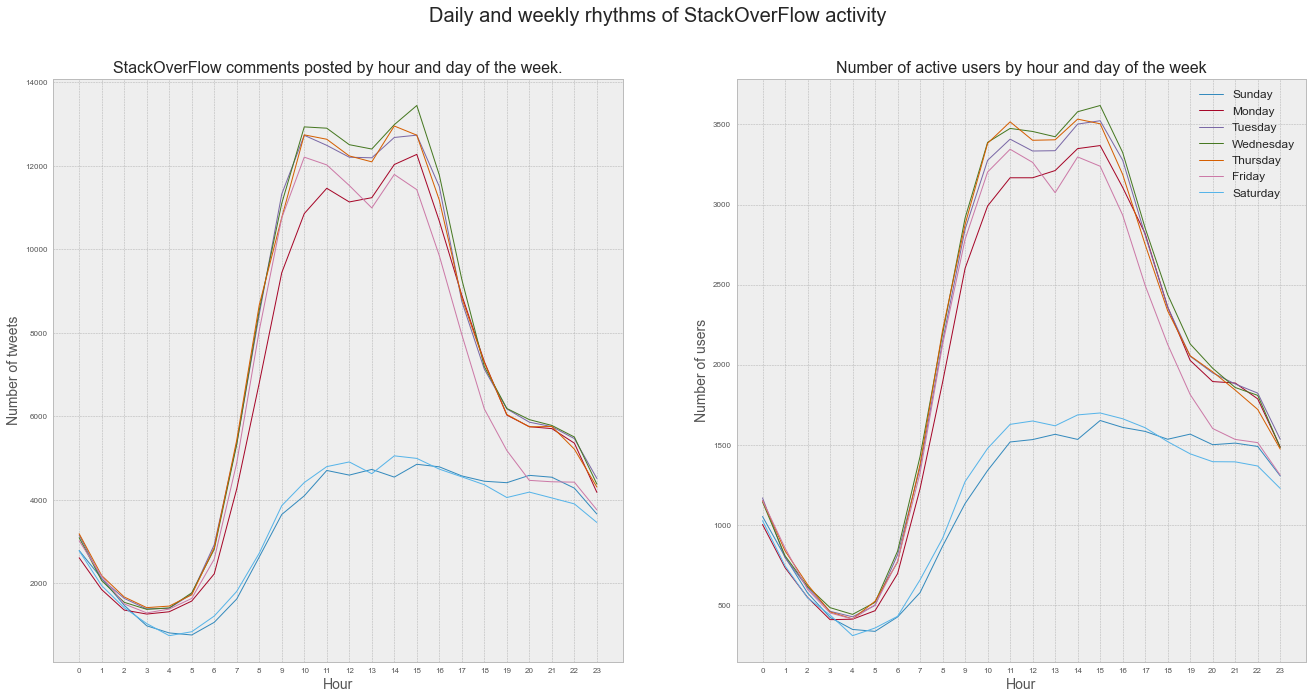

In [63]:
# List of days and hours, on which we iterate to plot data for each day and hour
days = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
hours = range(0,24,1)

# Grid with 2 plots, our graphs share the same x axis (list of hours)
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10), sharex = True)

for day in days:  
    
    # We slice on the data of our dataframes to recover only the data related to the day we are interested in.
    df_day_tweets = df_2a[df_2a.dayOfWeek == day]
    df_day_users = df_2b[df_2b.dayOfWeek == day]
    
    # We retrieve the count of active tweets/users after selecting only the day we are interested in.
    y_tweets = df_day_tweets.id
    y_users = df_day_users.id
    
    # Widht is set to q for clarity, we use plot to have a simple lineplot, the legend is the day 
    ax1.plot(hours,y_tweets,label=day,linewidth=1)
    ax2.plot(hours,y_users,label=day,linewidth=1)
    

# We define all the information specific to each subplot, the title of the subplot, and the labels of the x and y axes.     
ax1.set_title("StackOverFlow comments posted by hour and day of the week.",fontsize=16)
ax2.set_title("Number of active users by hour and day of the week",fontsize=16)   
ax1.set_xlabel('Hour',fontsize=14)
ax2.set_xlabel('Hour',fontsize=14)
ax1.set_ylabel('Number of tweets',fontsize=14)
ax2.set_ylabel('Number of users',fontsize=14)
    
# We define all information common to both graphs, the global title, the display and positioning of the legend, and the format of the x ticks.
plt.legend(fontsize=12)
plt.xticks(np.arange(0, 24, step=1))
plt.suptitle('Daily and weekly rhythms of StackOverFlow activity',fontsize=20)

plt.show()

# Figure aggregation and extras for the datastory
## 1. Aggregation of figures 2

Now that all the data has been computed in the precedent sections, by each member of the group, we can create new graphs to provide a side by side comparison between the replications of figures 2A and 2B with the different datasets used.

We'll start by loading data from the different pre-processing implementations (previously saved to .csv files), then if needed we'll process the data to standadize it. Finally, we'll use the same method as in the processing done for Reddit to generate the figures desired.  

In [74]:
#Usual imports to create dataframe, plots and to manipulate arrays
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#to see and export our graphs as .html files
import mpld3

## 1.1 Data loading and processing
For each dataset (Reddit, Twitter, Weibo and Stack Overflow), we want to obtain a dataframe containing the number of unique users active as well as the number of posts (tweets, comments or other, depending on the platform) at a given hour and for each day of the week. 

### 1.1.1 Reddit
Since we'll be using the same method for plotting, we only have to resume with the dataframe untouched

In [75]:
#read the data processed during the replication of the figure 2 with the reddit dataset
users_stats_reddit.head()

,weekday,time_hour,id,create_utc,comment_id,local_datetime
0,Friday,0,892,891,892,891
1,Friday,1,577,577,577,577
2,Friday,2,318,318,318,318
3,Friday,3,216,216,216,216
4,Friday,4,197,197,197,197


### 1.1.2 Weibo

In [76]:
#read the data processed during the replication of the figure 2 with the weibo dataset
weibo_data=data = pd.read_csv('data/Weibo_cyrcadian.csv')

#rename the columns for clarity
weibo_data=weibo_data.rename(columns={'Unnamed: 0': 'post_id','poster_id': 'id'})

#group by day and hour of the day
daily_activity_weibo = weibo_data.groupby(['Weekday','Hour'],as_index=False)

#create a dataframe with the number of posts and unique users at any given hour of any given day
users_stats_weibo=daily_activity_weibo.nunique()
users_stats_weibo.head()

,Weekday,Hour,post_id,id
0,Friday,0,180,114
1,Friday,1,102,57
2,Friday,2,65,43
3,Friday,3,42,33
4,Friday,4,31,27


### 1.1.3 Twitter
The reddit dataset has been generated by the member of the group that provided the method for this part of the figure replication, to facilitate the processing.

In [77]:
#read the data processed during the replication of the figure 2 with the twitter dataset
twitter_data=data = pd.read_csv('data/twitter_fig2.csv', index_col=0)
twitter_data.head()

,weekday,time_hour,id,tweetid,created_at,egoID,utc_offset,local_datetime
0,Friday,0,1521,20124,20022,1521,26,19703
1,Friday,1,1255,13351,13301,1255,23,13143
2,Friday,2,1027,9492,9253,1027,24,9183
3,Friday,3,872,7298,7265,872,25,7224
4,Friday,4,784,6581,6556,784,23,6524


### 1.1.4 Stack Overflow

In [78]:
#read the data processed during the replication of the figure 2 with the stackoverflow dataset
stackoverflow_data_2A=df_2a.copy()
stackoverflow_data_2A=stackoverflow_data_2A.rename(columns={'id': 'comment_id'})
stackoverflow_data_2B=df_2b.copy()

#create a new dataset and keep the info on question_id, user id (id) from both precedent datasets
stackoverflow_data=stackoverflow_data_2A.copy()
stackoverflow_data['id']=stackoverflow_data_2B.id
stackoverflow_data.head()

,dayOfWeek,hour,comment_id,id
0,Friday,0,3022,1153
1,Friday,1,2172,856
2,Friday,2,1510,598
3,Friday,3,1296,451
4,Friday,4,1387,413


## 1.1 Figure creation

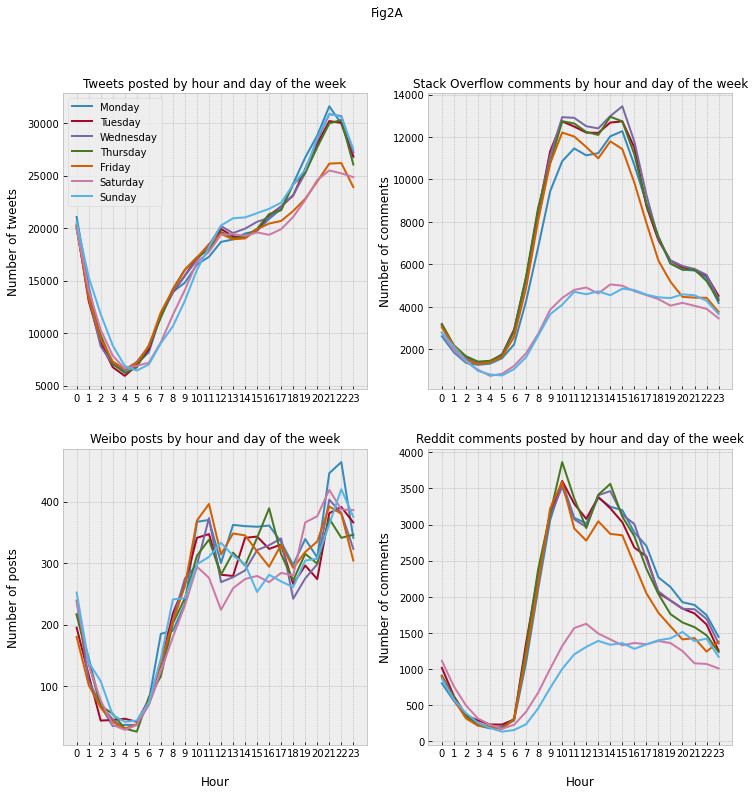

In [79]:
#for our graphs, we'll use the bmh style in matplotlib
plt.style.use('bmh')

days=['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

figa, axs = plt.subplots(2, 2, figsize=(12,12))
figa.suptitle('Comparison between the distribution of posts during the day across our platforms')

for day in days:
    #take data for one day at a time
    daily_twitter=twitter_data[twitter_data.weekday==day]
    daily_stackoverflow=stackoverflow_data[stackoverflow_data.dayOfWeek==day]
    daily_weibo=users_stats_weibo[users_stats_weibo.Weekday==day]
    daily_reddit=users_stats_reddit[users_stats_reddit.weekday==day]
    
    #plot number of comments,tweets or posts as a function of the hour
    axs[0,0].plot(daily_twitter.time_hour,daily_twitter.tweetid,label=day)
    axs[0,1].plot(daily_stackoverflow.hour,daily_stackoverflow.comment_id,label=day)
    axs[1,0].plot(daily_weibo.Hour,daily_weibo.post_id,label=day)
    axs[1,1].plot(daily_reddit.time_hour,daily_reddit.comment_id,label=day)
    
    
axs[0,0].set_title('Tweets posted by hour and day of the week',fontsize = 12)
axs[0,0].set_ylabel('Number of tweets')
axs[0,0].yaxis.set_label_coords(-0.14, 0.5)
axs[0,0].set_xticks(np.arange(0, 24, step=1))

axs[0,1].set_title('Stack Overflow comments by hour and day of the week',fontsize = 12)
axs[0,1].set_ylabel('Number of comments')
axs[0,1].yaxis.set_label_coords(-0.12, 0.5)
axs[1,0].set_xticks(np.arange(0, 24, step=1))

axs[1,0].set_title('Weibo posts by hour and day of the week',fontsize = 12)
axs[1,0].set_xlabel('Hour')
axs[1,0].set_ylabel('Number of posts')
axs[1,0].xaxis.set_label_coords(0.5, -0.1)
axs[1,0].yaxis.set_label_coords(-0.14, 0.5)
axs[0,1].set_xticks(np.arange(0, 24, step=1))

axs[1,1].set_title('Reddit comments posted by hour and day of the week',fontsize = 12)
axs[1,1].set_xlabel('Hour')
axs[1,1].set_ylabel('Number of comments')
axs[1,1].xaxis.set_label_coords(0.5, -0.1)
axs[1,1].yaxis.set_label_coords(-0.12, 0.5)
axs[1,1].set_xticks(np.arange(0, 24, step=1))

axs[0,0].legend()


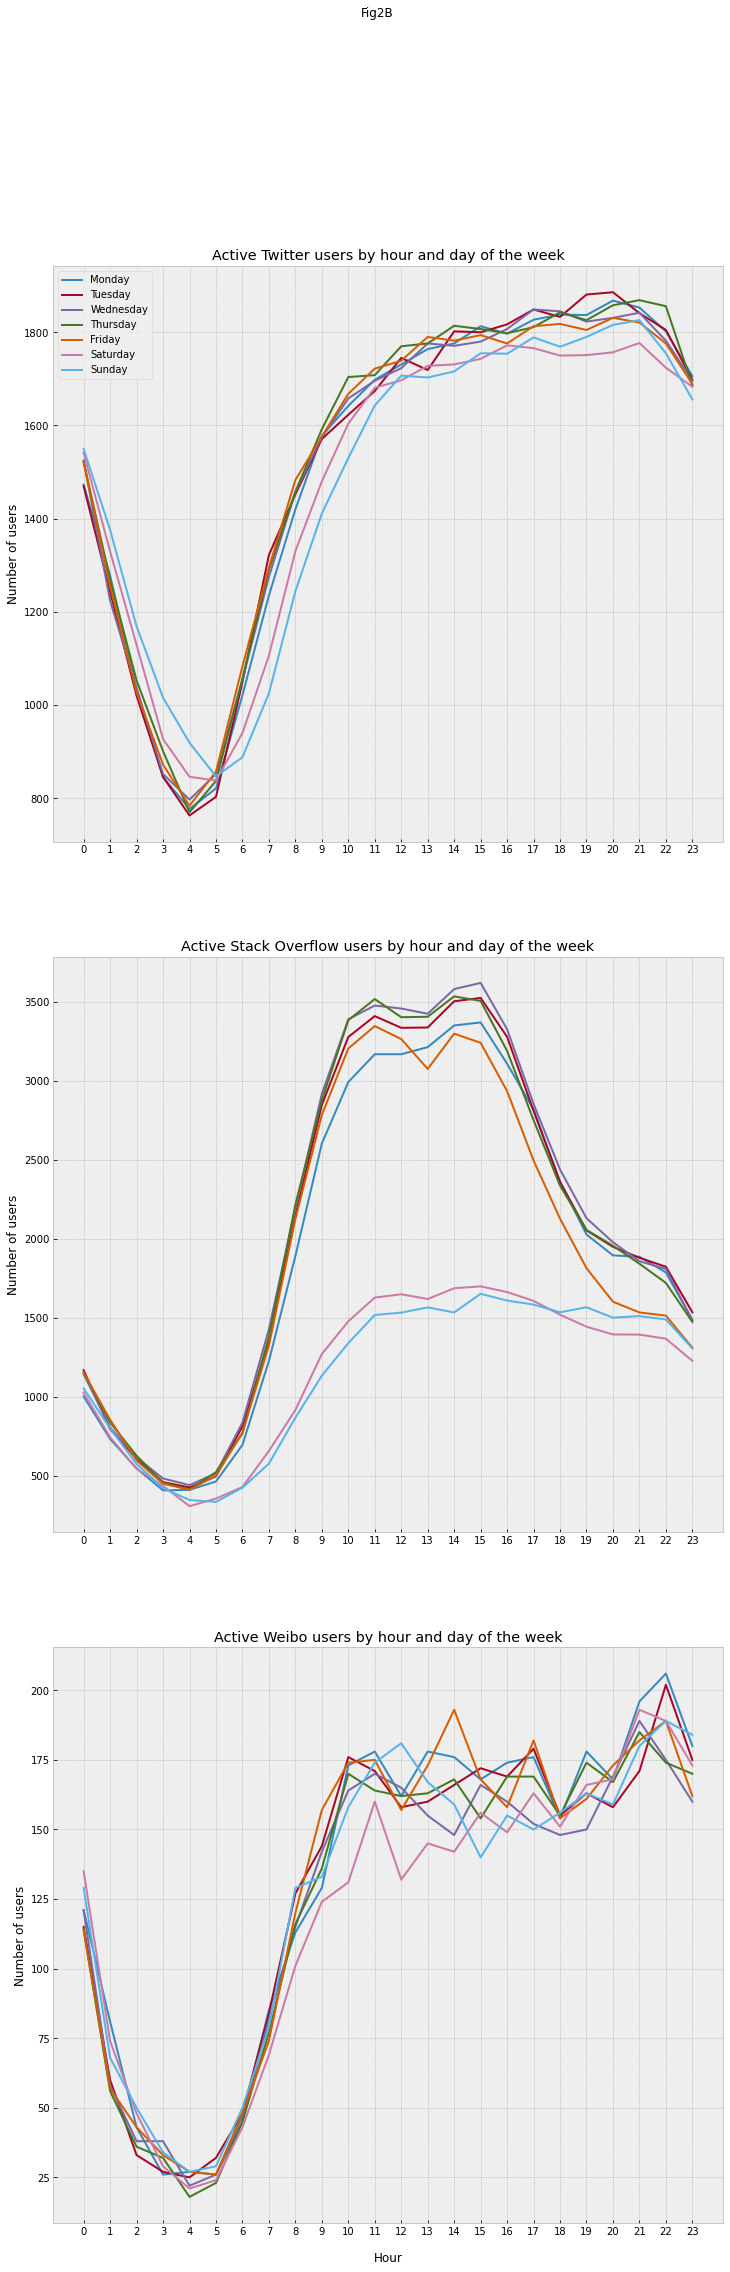

In [90]:
figb, axs = plt.subplots(3, figsize=(12,36))
figb.suptitle('Comparison between the distribution of active users during the day across our platforms')

for day in days:
    #take data for one day at a time
    daily_twitter=twitter_data[twitter_data.weekday==day]
    daily_stackoverflow=stackoverflow_data[stackoverflow_data.dayOfWeek==day]
    daily_weibo=users_stats_weibo[users_stats_weibo.Weekday==day]
    daily_reddit=users_stats_reddit[users_stats_reddit.weekday==day]
    
    #plot number of active users as a function of the hour
    axs[0].plot(daily_twitter.time_hour,daily_twitter.id,label=day)
    axs[1].plot(daily_stackoverflow.hour,daily_stackoverflow.id,label=day)
    axs[2].plot(daily_weibo.Hour,daily_weibo.id,label=day)
    
    
axs[0].set_title('Active Twitter users by hour and day of the week')
axs[0].set_ylabel('Number of users')
axs[0].set_xticks(np.arange(0, 24, step=1))

axs[1].set_title('Active Stack Overflow users by hour and day of the week')
axs[1].set_ylabel('Number of users')
axs[1].set_xticks(np.arange(0, 24, step=1))


axs[2].set_title('Active Weibo users by hour and day of the week')
axs[2].set_xlabel('Hour')
axs[2].set_ylabel('Number of users')
axs[2].xaxis.set_label_coords(0.5, -0.05)
axs[2].set_xticks(np.arange(0, 24, step=1))

axs[0].legend()

The figures can be saved to .html files, to be embedded in the datastory website, by uncommenting the next 2 cells.

In [81]:
#mpld3.display(figa)
#html_str = mpld3.fig_to_html(figa)
#Html_file= open("fig2a.html","w")
#Html_file.write(html_str)
#Html_file.close()

In [82]:
#mpld3.display(figb)
#html_str = mpld3.fig_to_html(figb)
#Html_file= open("fig2b.html","w")
#Html_file.write(html_str)
#Html_file.close()

## 1. Extras

To go further in our analysis, we can compute some extra analytics using our datasets. These results will be presented in our datastory.

### Repartitions of the posts across 'slices' of the day

In [2]:
def split_quadrants(column_data, column_hours):
    
    for beginning, end in zip([0,6,12,18],[6,12,18,24]):
        print('Proportion of posts created between '+str(beginning)+' and '+str(end)+' is '
              +str((sum(column_data[column_hours < end])-sum(column_data[column_hours < beginning]))/sum(column_data)))
    return

In [62]:
#for Reddit
print('Repartition of the posts across the 4 quadrants, regardless of the day on Reddit: ')
split_quadrants(users_stats_reddit.comment_id,users_stats_reddit.time_hour)
print('\n')

#for Weibo
print('Repartition of the posts across the 4 quadrants, regardless of the day on Weibo: ')
split_quadrants(users_stats_weibo.post_id,users_stats_weibo.Hour)
print('\n')

#for Twitter
print('Repartition of the posts across the 4 quadrants, regardless of the day on Twitter: ')
split_quadrants(twitter_data.tweetid,twitter_data.time_hour)
print('\n')

#for Stack Overflow
print('Repartition of the posts across the 4 quadrants, regardless of the day on Stack Overflow: ')
split_quadrants(stackoverflow_data.comment_id,stackoverflow_data.hour)

Repartition of the posts across the 4 quadrants, regardless of the day on Reddit: 
Proportion of posts created between 0 and 6 is 0.06691308243727599
Proportion of posts created between 6 and 12 is 0.289433990442055
Proportion of posts created between 12 and 18 is 0.3947991338112306
Proportion of posts created between 18 and 24 is 0.24885379330943846


Repartition of the posts across the 4 quadrants, regardless of the day on Weibo: 
Proportion of posts created between 0 and 6 is 0.09254772030461873
Proportion of posts created between 6 and 12 is 0.23187617446345565
Proportion of posts created between 12 and 18 is 0.32195134012461674
Proportion of posts created between 18 and 24 is 0.3536247651073089


Repartition of the posts across the 4 quadrants, regardless of the day on Twitter: 
Proportion of posts created between 0 and 6 is 0.15146640155753838
Proportion of posts created between 6 and 12 is 0.19215382026883027
Proportion of posts created between 12 and 18 is 0.28329031319020287
P

### Difference in number of posts created between the weekdays and weekends

In [36]:
#this function computes the ratio between the average number of posts on a weekday and the average number of posts on a weekend day
def weekend_weekday_ratio(column_data, column_weekday, weekday_list, weekend_list):

    weekday_posts=0
    weekday_posts_sum=0
    weekend_posts=0
    weekend_posts_sum=0
    for day in weekday_list:
        weekday_posts=sum(column_data[column_weekday==day])
        weekday_posts_sum=weekday_posts_sum+weekday_posts
    for day in weekend_list:
        weekend_posts=sum(column_data[column_weekday==day])
        
        weekend_posts_sum=weekend_posts_sum+weekend_posts
    weekday_avg=weekday_posts_sum/5
    weekend_avg=weekend_posts_sum/2

    ratio=weekday_avg/weekend_avg
    return ratio

In [39]:
weekday_list=['Monday','Tuesday','Wednesday', 'Thursday', 'Friday']
weekend_list=['Saturday','Sunday']

#let's see the difference in posts published between weekdays and weekends
print('Weekday/Weekend average posting ratio on Reddit: ' +str(weekend_weekday_ratio(users_stats_reddit.comment_id,users_stats_reddit.weekday,weekday_list, weekend_list)))
print('Weekday/Weekend average posting ratio on Weibo: ' +str(weekend_weekday_ratio(users_stats_weibo.post_id,users_stats_weibo.Weekday,weekday_list, weekend_list)))
print('Weekday/Weekend average posting ratio on Twitter: ' +str(weekend_weekday_ratio(twitter_data.tweetid,twitter_data.weekday,weekday_list, weekend_list)))
print('Weekday/Weekend average posting ratio on Stack Overflow: ' +str(weekend_weekday_ratio(stackoverflow_data.comment_id,stackoverflow_data.dayOfWeek,weekday_list, weekend_list)))

#let's see the difference in posts published between Sundays-Thursdays and Fridays-Saturdays on Twitter
SunThu=['Sunday', 'Monday','Tuesday','Wednesday', 'Thursday']
FriSat=['Friday','Saturday']
print('Sundays-Thursdays/Fridays-Saturdays average posting ratio on Twitter: ' +str(weekend_weekday_ratio(twitter_data.tweetid,twitter_data.weekday,SunThu, FriSat)))

Weekday/Weekend average posting ratio on Reddit: 1.9017230266832812
Weekday/Weekend average posting ratio on Weibo: 1.0371146841965
Weekday/Weekend average posting ratio on Twitter: 1.0222530312831988
Weekday/Weekend average posting ratio on Stack Overflow: 2.0342576577581877
Sundays-Thursdays/Fridays-Saturdays average posting ratio on Twitter: 1.0657345257886193


### When to ask a question on Stack Overflow

We use bigquery to get an answer to this question. The query takes place in several stages all the questions are taken and grouped according to hours and days. Afterward we join the questions and the answers in our dataset keeping only the answers whose date is less than the date of the question + 1 hour. We order them by hour publication and day of publication. Once we have all the needed data we can plot it.

In [ ]:
# Sql query for get the data through bigquery
query = """SELECT
  question_hour,
  question_day,
  COUNT(answer_id) as count_answers,
  COUNT(question_id) as count_questions,
  ROUND(COUNT(answer_id)/COUNT(question_id)*100,2) as percent_questions
FROM
  (SELECT
    EXTRACT(hour from q.creation_date) as question_hour,
    q.accepted_answer_id as answer_id,
    q.id as question_id,
    EXTRACT(DAYOFWEEK FROM q.creation_date) as question_day
   FROM 
    `bigquery-public-data.stackoverflow.posts_questions` q
   FULL JOIN
    `bigquery-public-data.stackoverflow.posts_answers` a ON q.id = a.parent_id
   WHERE
     a.creation_date < TIMESTAMP_ADD(q.creation_date, INTERVAL 1 hour)) 
GROUP BY
  question_day, question_hour
ORDER BY 
  question_day, question_hour
        """
# We load all the data thanks to bq_assistant
df_percent_response = bq_assistant.query_to_pandas(query)

In [69]:
# We modify the value to get the right correspondance between days in our dataframe and in our list
df_percent_response.question_day = df_percent_response -1

,question_hour,question_day,count_answers,count_questions,percent_questions
0,0,0,27729,39141,70.84
1,1,0,24348,34815,69.94
2,2,0,24034,34246,70.18
3,3,0,23330,33914,68.79
4,4,0,24211,35281,68.62
...,...,...,...,...,...
163,19,6,48030,68671,69.94
164,20,6,46061,65588,70.23
165,21,6,42137,59816,70.44
166,22,6,37632,53279,70.63


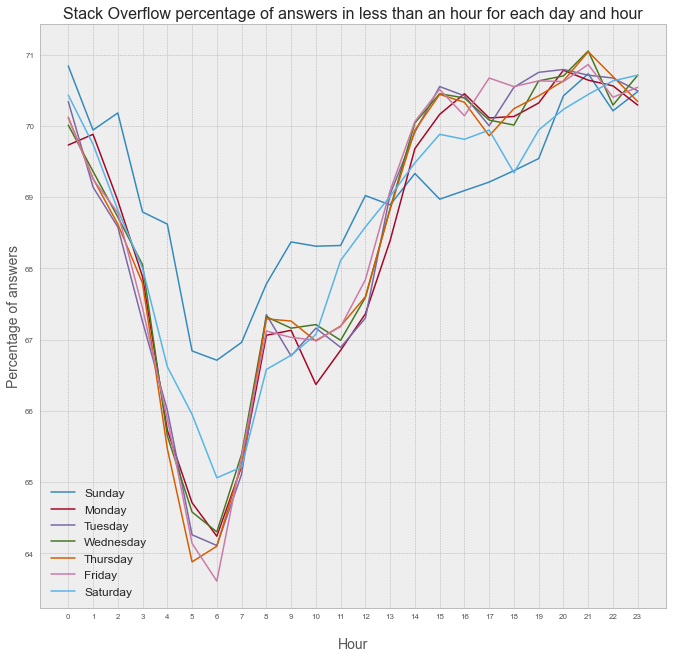

In [70]:
days = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
hours = range(0,24,1)
# Create our plot
plt.style.use('bmh')
f, ax = plt.subplots(1, 1,figsize=(10,10))

for n in range(0,7,1):  
    
    # We slice on the data of our dataframes to recover only the data related to the day we are interested in.
    df_day = df_percent_response[df_percent_response.question_day == n]
    
    # We retrieve the percentage responses only for the day we are interested in.
    y = df_day.percent_questions.values
    
    # Widht is set to q for clarity, we use plot to have a simple lineplot, the legend is the day 
    ax.plot(hours,y,label=days[n],linewidth=1.5)

    

# We define all the information specific to the plot, the title,the labels of the x and y axes, the display and positioning of the legend, and the format of the x ticks.
ax.set_title("Stack Overflow percentage of answers in less than an hour for each day and hour",fontsize=16)
ax.set_xlabel('Hour',fontsize=14)
ax.set_ylabel('Percentage of answers',fontsize=14)
ax.xaxis.set_label_coords(0.5, -0.05)
plt.legend(fontsize=12)
plt.xticks(np.arange(0, 24, step=1))


plt.show()